<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-задачи" data-toc-modified-id="Описание-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#исследуем-пропуски" data-toc-modified-id="исследуем-пропуски-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>исследуем пропуски</a></span><ul class="toc-item"><li><span><a href="#заполнение-пропусков" data-toc-modified-id="заполнение-пропусков-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>заполнение пропусков</a></span></li></ul></li></ul></li></ul></div>

## Описание задачи

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!
Предлагаем вам принять участие в Мастерской, в рамках которой вы сможете поработать с данными о продажах автомобилей на вторичном рынке. Целью вашего проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

В ходе работы в пройдете все основные этапы полноценного исследования:
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.

Описание датасета <br>
**Date**: Год выпуска автомобиля.<br>
**Make**: Марка автомобиля.<br>
**Model**: издание автомобиля определенной марки.<br>
**Trim**: Уровни отделки салона автомобиля — это просто разные версии модели.<br>
**Body**: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.<br>
**Transmission**: механизм, который передает мощность от двигателя к колесам.<br>
**VIN**: идентификационный номер транспортного средства.<br>
**State**: состояние, в котором автомобиль выставлен на аукцион.<br>
**Condition**: Состояние автомобилей на момент аукциона.<br>
**Odometer**: расстояние, пройденное автомобилем с момента выпуска.<br>
**Color**: Цвет кузова автомобиля.<br>
**Interior**: Цвет салона автомобиля.<br>
**Seller**: Продавец автомобиля, автосалоны.<br>
**mmr**: Рекорд рынка Manhiem, рыночная оценочная цена автомобилей.<br>
**sellingprice**: цена, по которой автомобиль был продан на аукционе.<br>
**saledate**: Дата продажи автомобиля.<br>


## Загрузка и подготовка данных

In [1]:
from IPython.display import display, HTML ## для удобства
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats as st
import seaborn as sns
import ydata_profiling
import missingno as msno
from pyvin import VIN
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
import catboost
import requests,json;
from sklearn import metrics
from catboost import CatBoostRegressor#, cross_validation
from catboost import Pool, cv

In [3]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 110058 entries, 0 to 110057

Data columns (total 14 columns):

 #   Column        Non-Null Count   Dtype  

---  ------        --------------   -----  

 0   year          110058 non-null  int64  

 1   make          107997 non-null  object 

 2   model         107979 non-null  object 

 3   trim          107944 non-null  object 

 4   body          107464 non-null  object 

 5   transmission  97047 non-null   object 

 6   vin           110058 non-null  object 

 7   state         110058 non-null  object 

 8   condition     107679 non-null  float64

 9   odometer      110039 non-null  float64

 10  color         109900 non-null  object 

 11  interior      109900 non-null  object 

 12  seller        110058 non-null  object 

 13  saledate      110058 non-null  object 

dtypes: float64(2), int64(1), object(11)

memory usage: 11.8+ MB


In [5]:
train['make']=train['make'].str.lower()
test['make']=test['make'].str.lower()
train['model']=train['model'].str.lower()
test['model']=test['model'].str.lower()

Преобразуем время во временной формат, добавим синтетический признак carage

In [6]:
train['saledate']=pd.to_datetime(train['saledate'].str[:-15], format = '%a %b %d %Y %H:%M:%S')
test['saledate']=pd.to_datetime(test['saledate'].str[:-15], format = '%a %b %d %Y %H:%M:%S')

train['sellingyear'] = pd.DatetimeIndex(train['saledate']).year
test['sellingyear'] = pd.DatetimeIndex(test['saledate']).year

train['carage'] = train['sellingyear']-train['year']
test['carage'] = test['sellingyear']-test['year']

воспользуемся ydata_profiling

In [7]:
# ydata_profiling.ProfileReport(train)

выделим численные и категориальные данные

In [8]:
numerical_columns=train._get_numeric_data().columns
train[numerical_columns].sample(10)

,year,condition,odometer,sellingprice,sellingyear,carage
58795,2010,3.6,77693.0,9100,2015,5
208573,2012,4.2,23680.0,12000,2015,3
224967,2006,2.6,159174.0,3100,2014,8
350365,2012,2.4,46832.0,15000,2015,3
186087,2003,2.0,124680.0,500,2015,12
48986,2010,4.4,57119.0,13100,2015,5
87128,2003,2.9,165115.0,3100,2015,12
397496,2013,2.4,37462.0,8200,2015,2
58007,2013,4.1,49966.0,41000,2015,2
432957,2014,3.8,31831.0,16800,2015,1


### исследуем пропуски

<AxesSubplot:>

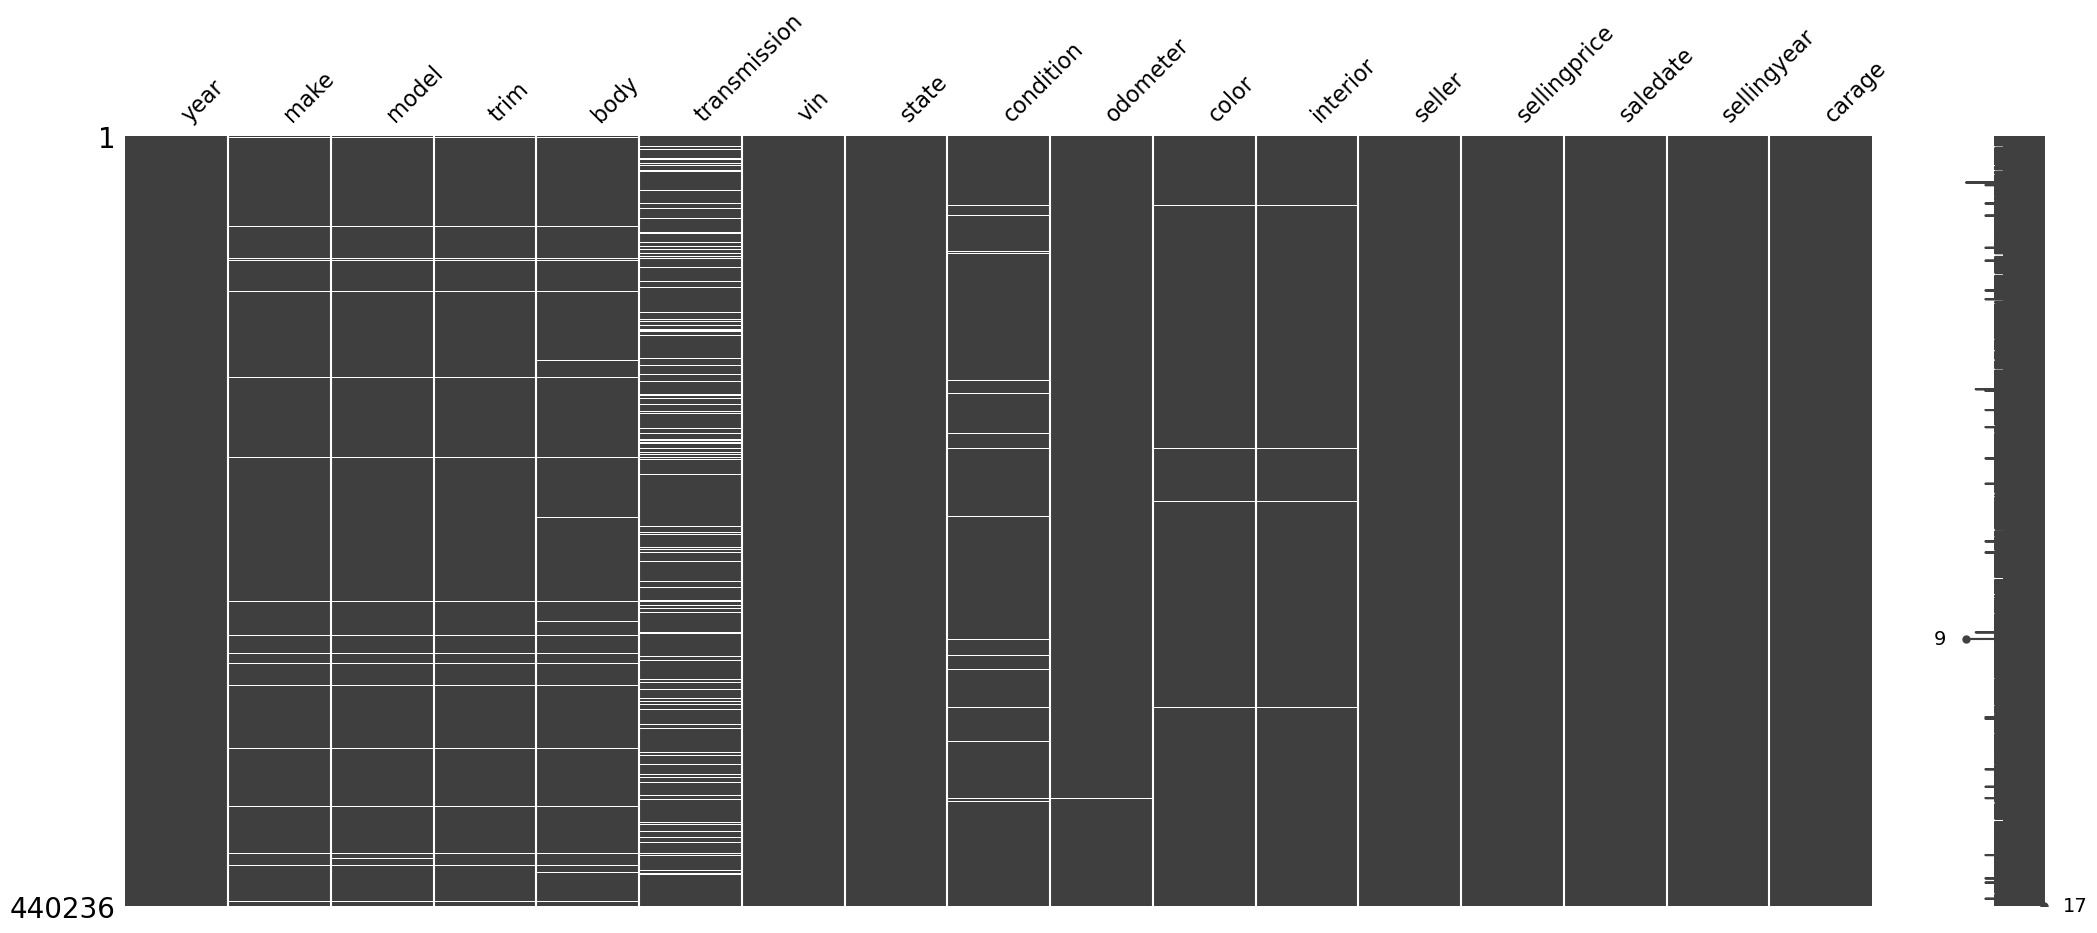

In [9]:
%matplotlib inline
msno.matrix(train)

In [10]:
test.isna().sum() # в train ситуация аналогичная

year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
sellingyear         0
carage              0
dtype: int64

#### заполнение пропусков

заполним для test

In [11]:
test_=test[['make','model','trim','body','transmission']]
vin_list = test[test_.isna().any(axis=1)]['vin']
isna_test  = pd.read_csv('datasets/test_miss.csv')[['VIN','Model','Make','BodyClass','Trim2','TransmissionStyle']].drop(index=0)
isna_test.index= test[test_.isna().any(axis=1)].index

In [12]:
vin_make= test.loc[test['make'].isna(),'vin']
test.loc[test['make'].isna(),'make'] = isna_test.loc[isna_test['VIN'].isin(vin_make)]['Make']

In [13]:
vin_model= test.loc[test['model'].isna(),'vin']
test.loc[test['model'].isna(),'model'] = isna_test.loc[isna_test['VIN'].isin(vin_model)]['Model']

In [14]:
vin_body= test.loc[test['body'].isna(),'vin']
test.loc[test['body'].isna(),'body'] = isna_test.loc[isna_test['VIN'].isin(vin_body)]['BodyClass']

In [15]:
test.isna().sum()

year                0
make                1
model              15
trim             2114
body               15
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
sellingyear         0
carage              0
dtype: int64

заполним для train

In [16]:
train_=train[['make','model','trim','body','transmission']]
vin_list = train[train_.isna().any(axis=1)]['vin']
isna_train  = pd.read_csv('datasets/train_miss.csv')[['VIN','Model','Make','BodyClass','Trim2','TransmissionStyle']].drop(index=0)
# train_miss.csv получен через запросы к базам VIN
isna_train.index= train[train_.isna().any(axis=1)].index

C:\Users\AlexeyAporoski\AppData\Local\Temp\ipykernel_5180\1660704892.py:3: DtypeWarning: Columns (2,39,56) have mixed types. Specify dtype option on import or set low_memory=False.

  isna_train  = pd.read_csv('datasets/train_miss.csv')[['VIN','Model','Make','BodyClass','Trim2','TransmissionStyle']].drop(index=0)


In [17]:
vin_make= train.loc[train['make'].isna(),'vin']
train.loc[train['make'].isna(),'make'] = isna_train.loc[isna_train['VIN'].isin(vin_make)]['Make']

In [18]:
vin_model= train.loc[train['model'].isna(),'vin']
train.loc[train['model'].isna(),'model'] = isna_train.loc[isna_train['VIN'].isin(vin_model)]['Model']

In [19]:
vin_body= train.loc[train['body'].isna(),'vin']
train.loc[train['body'].isna(),'body'] = isna_train.loc[isna_train['VIN'].isin(vin_body)]['BodyClass'].dtype

In [20]:
train.isna().sum()

year                0
make                6
model              54
trim             8337
body                0
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
sellingyear         0
carage              0
dtype: int64

In [21]:
train['body']=train['body'].str.lower()
test['body']=test['body'].str.lower()
train['body'].unique()

array(['suv', 'sedan', nan, 'wagon', 'minivan', 'extended cab',
       'regular cab', 'coupe', 'supercrew', 'convertible', 'crew cab',
       'supercab', 'hatchback', 'g coupe', 'g convertible', 'access cab',
       'g sedan', 'e-series van', 'quad cab', 'tsx sport wagon', 'van',
       'cts coupe', 'koup', 'king cab', 'double cab', 'elantra coupe',
       'crewmax cab', 'genesis coupe', 'g37 coupe', 'club cab',
       'beetle convertible', 'mega cab', 'regular-cab', 'xtracab',
       'q60 coupe', 'promaster cargo van', 'cts-v coupe', 'cts wagon',
       'cab plus 4', 'g37 convertible', 'transit van', 'q60 convertible',
       'cab plus', 'ram van', 'granturismo convertible', 'cts-v wagon'],
      dtype=object)

In [22]:
test['body'].value_counts()

sedan                                                      47484
suv                                                        28295
minivan                                                     5289
hatchback                                                   5152
coupe                                                       3658
wagon                                                       3311
crew cab                                                    3152
convertible                                                 2059
supercrew                                                   1731
g sedan                                                     1486
sport utility vehicle (suv)/multi-purpose vehicle (mpv)     1127
supercab                                                    1045
van                                                          993
extended cab                                                 922
regular cab                                                  918
quad cab                 

In [23]:
def categorize_body(row):
    try:
        if 'cab' in row:
                return 'cab'
        elif 'van' in row:
                return 'van'
        elif 'sedan' in row:
            return 'sedan'
        elif 'suv' in row:
            return 'suv'
        elif 'convert' in row:
            return 'convertible'
        elif 'wagon' in row:
            return 'wagon'
        elif 'coupe' in row:
            return 'coupe'
        else:
            return 'another'
    except:
        
        return 'another'
train['body'] = train['body'].apply(categorize_body)
test['body'] = test['body'].apply(categorize_body)
train['body'].unique()

array(['suv', 'sedan', 'another', 'wagon', 'van', 'cab', 'coupe',
       'convertible'], dtype=object)

In [24]:
train['make']=train['make'].str.lower()
test['make'] = train['make'].str.lower()
train['model']=train['model'].str.lower()
test['model']=test['model'].str.lower()

Применим функцию по заполнению пропусков в transmission, если у аналогичных моделей и марок, кузовов и года выпуска уже был указан только определенный один тип transmission

In [25]:
test.isna().sum()

year                0
make                1
model              15
trim             2114
body                0
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
sellingyear         0
carage              0
dtype: int64

In [26]:
test['body'].value_counts()

sedan          49565
suv            29422
cab             7499
another         7228
van             6766
coupe           4107
wagon           3322
convertible     2149
Name: body, dtype: int64

In [27]:
data = test
row=data.loc[0]
row

year                              2005
make                              ford
model                              cts
trim                              Base
body                             sedan
transmission                 automatic
vin                  1g6dp567450124779
state                               ca
condition                          2.7
odometer                      116970.0
color                           silver
interior                         black
seller          lexus of stevens creek
saledate           2015-01-14 04:30:00
sellingyear                       2015
carage                              10
Name: 0, dtype: object

In [28]:
data.loc[(data['year']==row['year'])&(data['model']==row['model'])&(data['trim']==row['trim'])]['transmission'].nunique() == 1

True

In [29]:
test.isna().sum()

year                0
make                1
model              15
trim             2114
body                0
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
sellingyear         0
carage              0
dtype: int64

In [30]:

def categorize_transmission(row):
    data = test

    
    if  row['transmission'] not in ['automatic','manual']:
        unique_n = data.loc[(data['year']==row['year'])&(data['model']==row['model'])&(data['trim']==row['trim'])]['transmission'].nunique()

        if unique_n==1:
            unique_transmission = data.loc[(data['year']==row['year'])&(data['model']==row['model'])&(data['trim']==row['trim']) ]['transmission'].unique()[0]
            print( 'changing NaN to ', unique_transmission)
            return unique_transmission 
    
# test['transmission']=test.apply(categorize_transmission,axis =1)

In [31]:
test.isna().sum()

year                0
make                1
model              15
trim             2114
body                0
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
sellingyear         0
carage              0
dtype: int64

Заполнение остальных пропусков test, train

In [32]:
test['transmission']=test['transmission'].fillna('unknown')
test['make']=test['make'].fillna('unknown')
test['model']=test['model'].fillna('unknown')
test['trim']=test['trim'].fillna('unknown')
test['interior']=test['interior'].fillna('unknown')
test['color']=test['color'].fillna('unknown')

In [33]:
test['condition']=test['condition'].fillna(0)
test['odometer']=test['odometer'].fillna(0)


In [34]:
test.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
sellingyear     0
carage          0
dtype: int64

Заполнение train

In [35]:
train.isna().sum()

year                0
make                6
model              54
trim             8337
body                0
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
sellingyear         0
carage              0
dtype: int64

In [36]:
train['trim']=train['trim'].fillna('unknown')
train['transmission']=train['transmission'].fillna('unknown')
train['odometer']=train['odometer'].fillna(0)

In [37]:
train['interior']=train['interior'].fillna('unknown')
train['color']=train['color'].fillna('unknown')
train['make']=train['make'].fillna('unknown')
train['model']=train['model'].fillna('unknown')
train['condition']=train['condition'].fillna(0)

убираем неинформативные для ML признаки

In [38]:
train=train.drop(['vin','saledate','color','interior','seller','sellingyear'],axis=1)
test=test.drop(['vin','saledate','color','interior','seller','sellingyear'],axis=1)

In [39]:
train.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
state           0
condition       0
odometer        0
sellingprice    0
carage          0
dtype: int64

Подготовка к ML

In [40]:
categoric_columns=train.select_dtypes(include=['object']).columns.tolist()
train[categoric_columns].sample(10)

,make,model,trim,body,transmission,state
166922,acura,rdx,Technology Package,suv,unknown,pa
327732,gmc,sierra 1500,SLE,cab,automatic,co
321450,dodge,charger,R/T,sedan,automatic,tx
403872,ford,e-series wagon,E-350 Super Duty XL,van,automatic,ca
1478,dodge,charger,R/T,sedan,automatic,fl
212207,nissan,altima,2.5,sedan,automatic,pa
187496,ford,focus,SE,another,automatic,il
152501,ford,edge,SEL,suv,automatic,mn
293036,volkswagen,rabbit,Base,another,automatic,fl
248108,ford,expedition,XLT,suv,automatic,mo


In [41]:
numerical_columns=train.drop('sellingprice',axis =1)._get_numeric_data().columns
train[numerical_columns].sample(10)

,year,condition,odometer,carage
108969,2011,3.5,79338.0,4
434255,2014,3.0,16292.0,1
436855,2014,4.9,4930.0,1
33421,2008,2.7,99737.0,7
399636,2003,1.9,234710.0,12
246738,2012,4.3,71367.0,3
286946,2013,1.9,57220.0,2
438763,2013,4.6,45861.0,2
434540,2008,3.8,80221.0,7
116746,2007,2.8,51792.0,8


In [42]:
train=train.reset_index(drop=True)

In [43]:
data_train, data_val = train_test_split(
    train, 
    test_size=0.25,
    random_state = 45,
    )

In [44]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 330177 entries, 85675 to 399774

Data columns (total 11 columns):

 #   Column        Non-Null Count   Dtype  

---  ------        --------------   -----  

 0   year          330177 non-null  int64  

 1   make          330177 non-null  object 

 2   model         330177 non-null  object 

 3   trim          330177 non-null  object 

 4   body          330177 non-null  object 

 5   transmission  330177 non-null  object 

 6   state         330177 non-null  object 

 7   condition     330177 non-null  float64

 8   odometer      330177 non-null  float64

 9   sellingprice  330177 non-null  int64  

 10  carage        330177 non-null  int64  

dtypes: float64(2), int64(3), object(6)

memory usage: 30.2+ MB


In [45]:
features_train= data_train.drop(['sellingprice'], axis=1)
target_train= data_train['sellingprice']

features_valid= data_val.drop(['sellingprice'], axis=1)
target_valid= data_val['sellingprice']

In [46]:

scaler=StandardScaler()
scaler.fit(features_train[numerical_columns])
features_train  [numerical_columns] = scaler.transform(features_train[numerical_columns])
features_valid  [numerical_columns] = scaler.transform(features_valid[numerical_columns])

In [47]:
#####
encoder = OrdinalEncoder()
features_train_encoded =  pd.DataFrame(encoder.fit_transform(features_train),columns=features_train.columns)
features_valid_encoded =  pd.DataFrame(encoder.fit_transform(features_valid),columns=features_valid.columns)

Выбор лучшей модели

In [48]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

In [49]:
model = LinearRegression()
model.fit(features_train_encoded, target_train)
predicted=model.predict(features_valid_encoded)
print('MAPE', mean_absolute_percentage_error (target_valid,predicted) ) #model.score(features_valid_encoded, target_valid))


MAPE 108.3362253063634


In [50]:
lm = LinearRegression()
lm.fit(features_train_encoded, target_train)
scores = cross_val_score(lm, features_valid_encoded, target_valid, scoring='r2', cv=5)
scores

array([0.46152273, 0.45612767, 0.45067043, 0.46141894, 0.46857698])

In [51]:
cat = CatBoostRegressor()

In [52]:
cat.fit(features_train_encoded,target_train,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [56]:
params = {"iterations": 100,
          "depth": 5,
          "loss_function": "MAPE",
          "verbose": False}
cv_dataset = Pool(data=features_valid_encoded,
                  label=target_valid)
scores = cv(cv_dataset,
            params,
            fold_count=10, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]



bestTest = 0.6319938194

bestIteration = 99



Training on fold [1/10]



bestTest = 0.6303960839

bestIteration = 99



Training on fold [2/10]



bestTest = 0.6383218249

bestIteration = 99



Training on fold [3/10]



bestTest = 0.6100256636

bestIteration = 99



Training on fold [4/10]



bestTest = 0.6265670448

bestIteration = 99



Training on fold [5/10]



bestTest = 0.5960000503

bestIteration = 99



Training on fold [6/10]



bestTest = 0.6077352304

bestIteration = 99



Training on fold [7/10]



bestTest = 0.6260225592

bestIteration = 99



Training on fold [8/10]



bestTest = 0.6278606054

bestIteration = 99



Training on fold [9/10]



bestTest = 0.6211138086

bestIteration = 99




тестирование лучшей модели

выбираем catboostregressor


In [62]:
data_test = tebst
# test.isna().sum()

In [65]:
data_test

,year,make,model,trim,body,transmission,state,condition,odometer,carage
0,2005,ford,cts,Base,sedan,automatic,ca,2.7,116970.0,10
1,2014,ford,savana cargo,2500,van,unknown,pa,4.4,6286.0,1
2,2013,nissan,murano,S,suv,automatic,oh,4.6,11831.0,2
3,2013,hummer,impala,LS Fleet,sedan,automatic,fl,2.3,57105.0,2
4,2013,ford,titan,SV,cab,automatic,tn,2.9,31083.0,2
...,...,...,...,...,...,...,...,...,...,...
110053,2011,chevrolet,wrangler,Sport,suv,automatic,ca,3.8,66085.0,4
110054,2014,chevrolet,is 250,Base,sedan,automatic,fl,4.8,17588.0,1
110055,2004,chevrolet,maxima,3.5 SL,sedan,automatic,va,2.9,124036.0,11
110056,2013,jeep,370z,Base,coupe,manual,tx,2.2,27169.0,2


In [66]:
# data_test = test
features_test=data_test;
# features_test= data_test.drop(['sellingprice'], axis=1)
# target_train= data_train['sellingprice']

# features_valid= data_val.drop(['sellingprice'], axis=1)
# target_valid= data_val['sellingprice']


# scaler=StandardScaler()
# scaler.fit(features_train[numerical_columns])
features_test  [numerical_columns] = scaler.transform(features_test[numerical_columns])
# features_valid  [numerical_columns] = scaler.transform(features_valid[numerical_columns])

#####
# encoder = OrdinalEncoder()
features_test_encoded =  pd.DataFrame(encoder.fit_transform(features_test),columns=features_test.columns)
# features_valid_encoded =  pd.DataFrame(encoder.fit_transform(features_valid),columns=features_valid.columns)

In [86]:
prediction = cat.predict(features_test_encoded)

In [87]:
prediction=pd.DataFrame(index=test.index, data = prediction)
prediction['vin']=test = pd.read_csv('datasets/test.csv')['vin']
# prediction.colums=['sellingprice']
prediction.columns = ['sellingprice','vin']
prediction = prediction [['vin','sellingprice']]
prediction

,vin,sellingprice
0,1g6dp567450124779,5961.872948
1,1gtw7fca7e1902207,34024.829011
2,jn8az1mw6dw303497,36872.381066
3,2g1wf5e34d1160703,13817.262759
4,1n6aa0ec3dn301209,21829.535214
...,...,...
110053,1j4aa2d17bl584330,18478.473895
110054,jthbf1d23e5007526,32362.447518
110055,1n4ba41e54c831950,2959.168139
110056,jn1az4eh3dm382431,22902.550617


In [88]:
prediction.to_csv('prediction.csv',index=False)